# Ensemble Model for TDE Classification

This notebook combines all trained models into the final submission.

**Steps:**
1. Load OOF and Test predictions from all models
2. Optimize weights using Log Loss minimization
3. Optimize threshold using F1 Score maximization
4. Generate final submission

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.metrics import log_loss, precision_recall_curve, f1_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [ ]:
# Configuration
RANDOM_STATE = 15

# Paths
DATA_DIR = os.path.join('..', 'data', 'processed')
MODEL_DIR = os.path.join('..', 'models')
SUBMISSION_DIR = os.path.join('..', 'submissions')
RAW_DIR = os.path.join('..', 'data', 'raw')

FOLDS_PATH = os.path.join(DATA_DIR, 'train_folds.csv')
TEST_RAW_PATH = os.path.join(RAW_DIR, 'test_log.csv')

os.makedirs(SUBMISSION_DIR, exist_ok=True)

# Model names to ensemble
MODEL_NAMES = ['xgb', 'lgb', 'cat', 'resnet']

In [3]:
# Load ground truth
print("Loading ground truth and predictions...")
folds_df = pd.read_csv(FOLDS_PATH)
print(f"Folds shape: {folds_df.shape}")

# Load OOF predictions
oof_dfs = {}
for name in MODEL_NAMES:
    path = os.path.join(MODEL_DIR, f'oof_{name}.csv')
    if os.path.exists(path):
        oof_dfs[name] = pd.read_csv(path)
        print(f"Loaded OOF {name}: {oof_dfs[name].shape}")
    else:
        print(f"Warning: {path} not found, skipping {name}")

# Load Test predictions
test_dfs = {}
for name in MODEL_NAMES:
    path = os.path.join(MODEL_DIR, f'preds_{name}.csv')
    if os.path.exists(path):
        test_dfs[name] = pd.read_csv(path)
        print(f"Loaded Test {name}: {test_dfs[name].shape}")
    else:
        print(f"Warning: {path} not found, skipping {name}")

# Update MODEL_NAMES to only include available models
MODEL_NAMES = [name for name in MODEL_NAMES if name in oof_dfs and name in test_dfs]
print(f"\nAvailable models for ensemble: {MODEL_NAMES}")

Loading ground truth and predictions...
Folds shape: (3043, 3)
Loaded OOF xgb: (3043, 3)
Loaded OOF lgb: (3043, 3)
Loaded OOF cat: (3043, 3)
Loaded OOF nn: (3043, 3)
Loaded Test xgb: (7135, 2)
Loaded Test lgb: (7135, 2)
Loaded Test cat: (7135, 2)
Loaded Test nn: (7135, 2)

Available models for ensemble: ['xgb', 'lgb', 'cat', 'nn']


In [4]:
# Merge OOF predictions on object_id
print("\nMerging OOF predictions...")
oof_merged = folds_df[['object_id', 'target']].copy()

for name in MODEL_NAMES:
    pred_col = f'pred_{name}'
    oof_merged = oof_merged.merge(
        oof_dfs[name][['object_id', pred_col]], 
        on='object_id', 
        how='left'
    )

print(f"Merged OOF shape: {oof_merged.shape}")
print(f"Columns: {oof_merged.columns.tolist()}")

# Merge Test predictions on object_id
print("\nMerging Test predictions...")
test_merged = test_dfs[MODEL_NAMES[0]][['object_id']].copy()

for name in MODEL_NAMES:
    pred_col = f'pred_{name}'
    test_merged = test_merged.merge(
        test_dfs[name][['object_id', pred_col]], 
        on='object_id', 
        how='left'
    )

print(f"Merged Test shape: {test_merged.shape}")
print(f"Columns: {test_merged.columns.tolist()}")


Merging OOF predictions...
Merged OOF shape: (3043, 6)
Columns: ['object_id', 'target', 'pred_xgb', 'pred_lgb', 'pred_cat', 'pred_nn']

Merging Test predictions...
Merged Test shape: (7135, 5)
Columns: ['object_id', 'pred_xgb', 'pred_lgb', 'pred_cat', 'pred_nn']


In [5]:
# Prepare arrays for optimization
y_true = oof_merged['target'].values
oof_preds = np.column_stack([oof_merged[f'pred_{name}'].values for name in MODEL_NAMES])
test_preds = np.column_stack([test_merged[f'pred_{name}'].values for name in MODEL_NAMES])

print(f"Target shape: {y_true.shape}")
print(f"OOF predictions shape: {oof_preds.shape}")
print(f"Test predictions shape: {test_preds.shape}")
print(f"\nClass distribution: {np.bincount(y_true.astype(int))}")

Target shape: (3043,)
OOF predictions shape: (3043, 4)
Test predictions shape: (7135, 4)

Class distribution: [2895  148]



=== Model Correlation Analysis ===



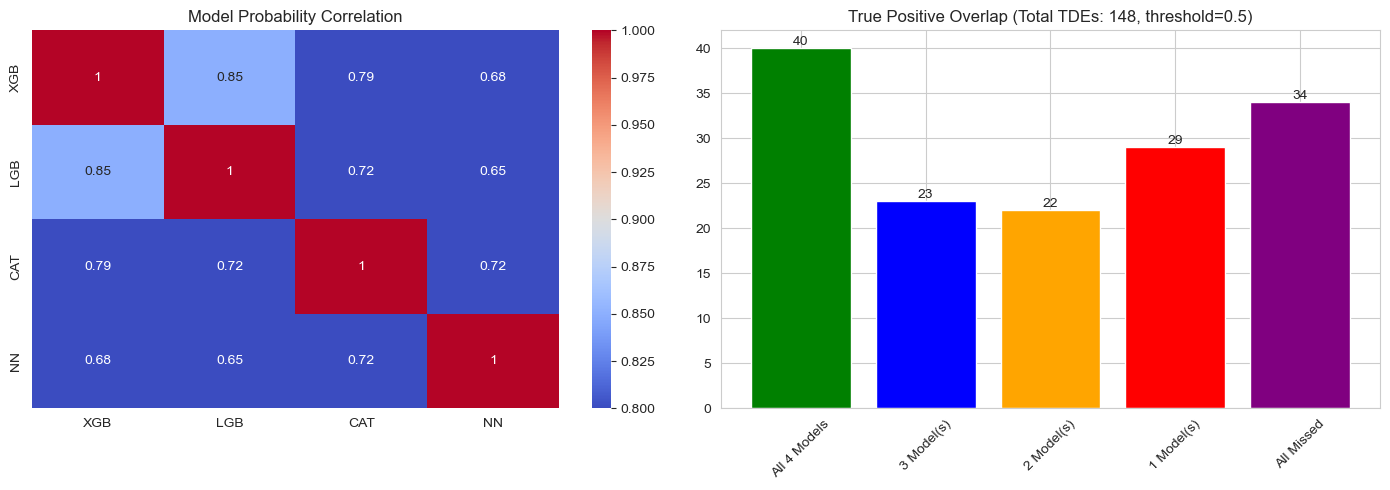

--- Overlap Insights ---
If lower model counts have high values, your models find DIFFERENT TDEs (Ensemble helps a lot).
If 'All N Models' is high, your models are similar (Ensemble will stabilize but boost less).


In [6]:
# Model Correlation Analysis
print("\n=== Model Correlation Analysis ===\n")

# Create probability DataFrame
probs_df = pd.DataFrame({name.upper(): oof_merged[f'pred_{name}'].values for name in MODEL_NAMES})

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 1. Correlation Heatmap (Probability Rank Alignment) ---
sns.heatmap(probs_df.corr(), annot=True, cmap='coolwarm', vmin=0.8, vmax=1.0, ax=axes[0])
axes[0].set_title('Model Probability Correlation')

# --- 2. Binary Overlap (Decision Agreement) ---
# Use a temporary threshold (0.5) for initial visualization
temp_threshold = 0.5
binary_df = pd.DataFrame({name.upper(): (oof_merged[f'pred_{name}'].values >= temp_threshold).astype(int) for name in MODEL_NAMES})
binary_df['Sum'] = binary_df.sum(axis=1)
binary_df['Target'] = y_true

# Count overlaps for true positives
n_models = len(MODEL_NAMES)
overlap_counts = []
categories = []
colors = ['green', 'blue', 'orange', 'red', 'purple'][:n_models + 1]

for i in range(n_models, -1, -1):
    count = len(binary_df[(binary_df['Sum'] == i) & (binary_df['Target'] == 1)])
    overlap_counts.append(count)
    if i == n_models:
        categories.append(f'All {n_models} Models')
    elif i == 0:
        categories.append('All Missed')
    else:
        categories.append(f'{i} Model(s)')

bars = axes[1].bar(categories, overlap_counts, color=colors[:len(categories)])
axes[1].set_title(f'True Positive Overlap (Total TDEs: {int(y_true.sum())}, threshold=0.5)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].bar_label(bars)

plt.tight_layout()
plt.show()

print("--- Overlap Insights ---")
print("If lower model counts have high values, your models find DIFFERENT TDEs (Ensemble helps a lot).")
print("If 'All N Models' is high, your models are similar (Ensemble will stabilize but boost less).")

In [7]:
# Optimization Phase 1: Optimize weights to minimize Log Loss
print("\n=== Phase 1: Optimizing Weights (Minimize Log Loss) ===")

def weighted_logloss(weights):
    """Calculate log loss for weighted ensemble."""
    # Normalize weights to sum to 1
    w = np.array(weights)
    w = w / np.sum(w)
    
    # Calculate weighted predictions
    weighted_preds = np.sum(oof_preds * w, axis=1)
    
    # Clip predictions to avoid log(0)
    weighted_preds = np.clip(weighted_preds, 1e-7, 1 - 1e-7)
    
    return log_loss(y_true, weighted_preds)

# Initial weights (equal)
n_models = len(MODEL_NAMES)
initial_weights = [1.0 / n_models] * n_models

# Constraints: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Bounds: each weight between 0 and 1
bounds = [(0, 1) for _ in range(n_models)]

# Optimize using SLSQP
np.random.seed(RANDOM_STATE)
result = minimize(
    weighted_logloss,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-9}
)

optimal_weights = result.x / np.sum(result.x)  # Normalize

print(f"\nOptimization success: {result.success}")
print(f"Final Log Loss: {result.fun:.6f}")
print(f"\nOptimal Weights:")
for name, weight in zip(MODEL_NAMES, optimal_weights):
    print(f"  {name.upper()}: {weight:.4f}")


=== Phase 1: Optimizing Weights (Minimize Log Loss) ===

Optimization success: True
Final Log Loss: 0.102570

Optimal Weights:
  XGB: 0.4736
  LGB: 0.2687
  CAT: 0.1260
  NN: 0.1317


In [8]:
# Optimization Phase 2: Optimize threshold to maximize F1 Score
print("\n=== Phase 2: Optimizing Threshold (Maximize F1 Score) ===")

# Calculate weighted OOF predictions
weighted_oof = np.sum(oof_preds * optimal_weights, axis=1)

# Method 1: Using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, weighted_oof)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold_prc = thresholds[best_idx]
best_f1_prc = f1_scores[best_idx]

print(f"\nMethod 1 (Precision-Recall Curve):")
print(f"  Best Threshold: {best_threshold_prc:.4f}")
print(f"  Best F1 Score: {best_f1_prc:.4f}")

# Method 2: Grid search from 0.01 to 0.99
thresholds_grid = np.arange(0.01, 0.99, 0.01)
f1_grid = []

for thresh in thresholds_grid:
    preds_binary = (weighted_oof >= thresh).astype(int)
    f1 = f1_score(y_true, preds_binary)
    f1_grid.append(f1)

best_idx_grid = np.argmax(f1_grid)
best_threshold_grid = thresholds_grid[best_idx_grid]
best_f1_grid = f1_grid[best_idx_grid]

print(f"\nMethod 2 (Grid Search):")
print(f"  Best Threshold: {best_threshold_grid:.4f}")
print(f"  Best F1 Score: {best_f1_grid:.4f}")

# Use the threshold that gives better F1
if best_f1_prc >= best_f1_grid:
    best_threshold = best_threshold_prc
    best_f1 = best_f1_prc
    print(f"\nUsing Precision-Recall Curve threshold.")
else:
    best_threshold = best_threshold_grid
    best_f1 = best_f1_grid
    print(f"\nUsing Grid Search threshold.")

print(f"\n=== Final Selected Threshold: {best_threshold:.4f} ===")
print(f"=== Final F1 Score (OOF): {best_f1:.4f} ===")


=== Phase 2: Optimizing Threshold (Maximize F1 Score) ===

Method 1 (Precision-Recall Curve):
  Best Threshold: 0.1940
  Best F1 Score: 0.6113

Method 2 (Grid Search):
  Best Threshold: 0.2000
  Best F1 Score: 0.6082

Using Precision-Recall Curve threshold.

=== Final Selected Threshold: 0.1940 ===
=== Final F1 Score (OOF): 0.6113 ===



=== Binary Overlap with Optimal Threshold ===


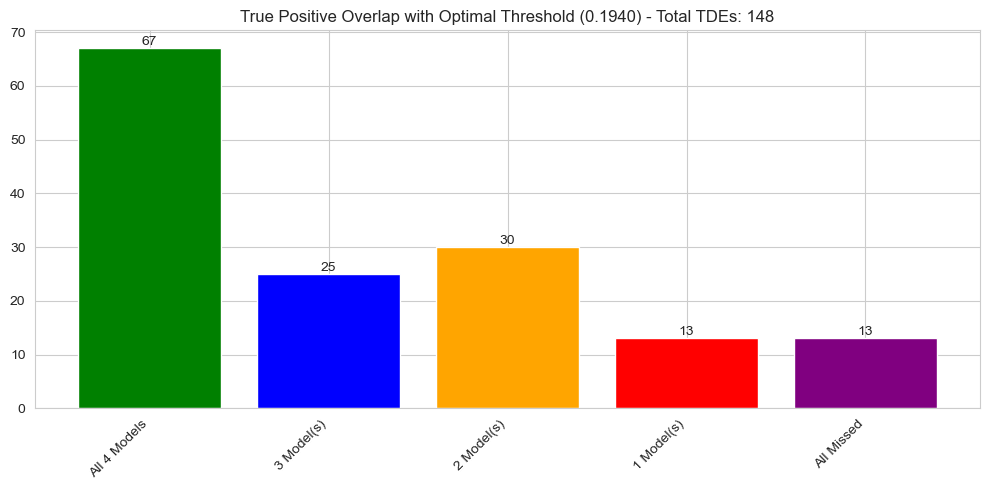

In [9]:
# Updated Binary Overlap with Optimal Threshold
print("\n=== Binary Overlap with Optimal Threshold ===")

binary_df = pd.DataFrame({name.upper(): (oof_merged[f'pred_{name}'].values >= best_threshold).astype(int) for name in MODEL_NAMES})
binary_df['Sum'] = binary_df.sum(axis=1)
binary_df['Target'] = y_true

# Count overlaps
n_models = len(MODEL_NAMES)
overlap_counts = []
categories = []
colors = ['green', 'blue', 'orange', 'red', 'purple'][:n_models + 1]

for i in range(n_models, -1, -1):
    count = len(binary_df[(binary_df['Sum'] == i) & (binary_df['Target'] == 1)])
    overlap_counts.append(count)
    if i == n_models:
        categories.append(f'All {n_models} Models')
    elif i == 0:
        categories.append('All Missed')
    else:
        categories.append(f'{i} Model(s)')

plt.figure(figsize=(10, 5))
bars = plt.bar(categories, overlap_counts, color=colors[:len(categories)])
plt.title(f'True Positive Overlap with Optimal Threshold ({best_threshold:.4f}) - Total TDEs: {int(y_true.sum())}')
plt.xticks(rotation=45, ha='right')
plt.bar_label(bars)
plt.tight_layout()
plt.show()

In [10]:
# Generate final submission
print("\n=== Generating Final Submission ===")

# Calculate weighted test predictions
weighted_test = np.sum(test_preds * optimal_weights, axis=1)

# Apply threshold
test_binary = (weighted_test >= best_threshold).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'object_id': test_merged['object_id'],
    'target': test_binary
})

print(f"Submission shape: {submission.shape}")
print(f"Prediction distribution: {np.bincount(test_binary)}")
print(f"Positive rate: {test_binary.mean():.4f}")


=== Generating Final Submission ===
Submission shape: (7135, 2)
Prediction distribution: [6578  557]
Positive rate: 0.0781


In [11]:
# Verify row count matches test_log.csv
print("\n=== Verification ===")

if os.path.exists(TEST_RAW_PATH):
    test_raw = pd.read_csv(TEST_RAW_PATH)
    expected_rows = len(test_raw['object_id'].unique())
    actual_rows = len(submission)
    
    print(f"Expected rows (from test_log.csv): {expected_rows}")
    print(f"Actual rows in submission: {actual_rows}")
    
    if expected_rows == actual_rows:
        print("✓ Row count matches!")
    else:
        print(f"✗ Row count mismatch! Difference: {actual_rows - expected_rows}")
else:
    print(f"Warning: {TEST_RAW_PATH} not found, skipping verification.")


=== Verification ===
Expected rows (from test_log.csv): 7135
Actual rows in submission: 7135
✓ Row count matches!


In [12]:
# Save submission
submission_path = os.path.join(SUBMISSION_DIR, 'submission_ensemble_v1.csv')
submission.to_csv(submission_path, index=False)

print(f"\n=== Submission saved to: {submission_path} ===")
print(f"\nSubmission preview:")
print(submission.head(10))


=== Submission saved to: ..\submissions\submission_ensemble_v1.csv ===

Submission preview:
                object_id  target
0    Dornhoth_adar_imrath       0
1    Dornhoth_celeb_achad       0
2    Dornhoth_firion_fern       0
3      Dornhoth_glae_aras       1
4  Dornhoth_lain_tinuviel       1
5   Dornhoth_lebed_lembas       0
6     Dornhoth_lobor_rust       0
7  Dornhoth_luin_gondrath       1
8  Dornhoth_minai_mithren       1
9      Dornhoth_nestad_hu       0


In [13]:
# Summary
print("\n" + "="*60)
print("ENSEMBLE SUMMARY")
print("="*60)
print(f"\nModels used: {MODEL_NAMES}")
print(f"\nOptimal Weights:")
for name, weight in zip(MODEL_NAMES, optimal_weights):
    print(f"  {name.upper()}: {weight:.4f}")
print(f"\nOptimal Threshold: {best_threshold:.4f}")
print(f"OOF F1 Score: {best_f1:.4f}")
print(f"OOF Log Loss: {result.fun:.6f}")
print(f"\nTest Predictions:")
print(f"  Total samples: {len(test_binary)}")
print(f"  Predicted positives: {test_binary.sum()}")
print(f"  Predicted negatives: {len(test_binary) - test_binary.sum()}")
print("="*60)


ENSEMBLE SUMMARY

Models used: ['xgb', 'lgb', 'cat', 'nn']

Optimal Weights:
  XGB: 0.4736
  LGB: 0.2687
  CAT: 0.1260
  NN: 0.1317

Optimal Threshold: 0.1940
OOF F1 Score: 0.6113
OOF Log Loss: 0.102570

Test Predictions:
  Total samples: 7135
  Predicted positives: 557
  Predicted negatives: 6578
